# Use Machine Learning in a Trading Strategy

## Loading and Preparing the Data

In [2]:
# Import required libraries
import pandas as pd
from pathlib import Path

In [3]:
# Import the OHLCV dataset into a Pandas Dataframe
trading_df = pd.read_csv(
    Path("Resources/final_df_without_y.csv"), 
    index_col="Unnamed: 0", 
    infer_datetime_format=True, 
    parse_dates=True
)

# Display sample data
trading_df.head()

,positive,negative,compound,actual_returns,target_return,Close
2022-05-31 00:04:00+00:00,27,18,0.263006,0.000528,0.000418,31734.792969
2022-05-31 00:06:00+00:00,41,18,0.281656,0.000418,0.000285,31751.789062
2022-05-31 00:08:00+00:00,45,36,0.149611,0.000285,0.000119,31783.402344
2022-05-31 00:10:00+00:00,53,26,0.314945,0.000119,0.000544,31775.460938
2022-05-31 00:12:00+00:00,65,30,0.418451,0.000544,-0.000480,31796.031250


### Creating the Target Set

In [4]:
# Create a new column in the `trading_df` called "signal" setting its value to zero.
trading_df["signal"] = 0.0

In [5]:
# Create the signal to buy
trading_df.loc[(trading_df["actual_returns"] >= 0), "signal"] = 1

In [6]:
# Create the signal to sell
trading_df.loc[(trading_df["actual_returns"] < 0), "signal"] = -1

In [7]:
# Copy the new "signal" column to a new Series called `y`.
y = trading_df["signal"].copy()

## Split the Data into Training and Testing Sets

In [8]:
# Import required libraries
from pandas.tseries.offsets import DateOffset

In [9]:
X = trading_df[["positive","negative","compound", "Close"]]

# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2022-05-31 00:04:00+00:00


## Split the Data into Training and Testing Sets

In [10]:
# Import required libraries
from pandas.tseries.offsets import DateOffset

In [11]:
# Select the ending period for the training data with an offset of 3 months
training_end = X.index.min() + DateOffset(days=2)

# Display the training end date
print(training_end)

2022-06-02 00:04:00+00:00


In [12]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

In [13]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end:]
y_test = y.loc[training_end:]

## Standardize the Data

In [14]:
# Import required libraries
from sklearn.preprocessing import StandardScaler

In [16]:
# Create a StandardScaler instancCloseCC
scaler = StandardScaler()
 
# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)
 
# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

---

## Using Machine Learning Into a Trading Strategy

In [17]:
# Import the SVM model
from sklearn import svm
from sklearn.metrics import classification_report

In [18]:
# Create the classifier model
svm_model = svm.SVC()
 
# Fit the model to the data using X_train_scaled and y_train
svm_model = svm_model.fit(X_train_scaled, y_train)

# Use the trained model to predict the trading signals for the training data
training_signal_predictions = svm_model.predict(X_train_scaled)

# Display the sample predictions
training_signal_predictions[:10]

array([ 1., -1.,  1.,  1.,  1.,  1., -1., -1.,  1.,  1.])

In [19]:
# Evaluate the model using a classification report
training_report = classification_report(y_train, training_signal_predictions)

# Display the report
print(training_report)

              precision    recall  f1-score   support

        -1.0       0.57      0.48      0.52       932
         1.0       0.56      0.65      0.60       936

    accuracy                           0.56      1868
   macro avg       0.56      0.56      0.56      1868
weighted avg       0.56      0.56      0.56      1868



### Backtesting a Machine Learning Trading Algorithm

In [20]:
# Use the trained model to predict the trading signals for the testing data.
testing_signal_predictions = svm_model.predict(X_test_scaled)

In [21]:
# Evaluate the model's ability to predict the trading signal for the testing data
testing_report = classification_report(y_test, testing_signal_predictions)

# Display the report
print(testing_report)

              precision    recall  f1-score   support

        -1.0       0.52      0.54      0.53      1734
         1.0       0.51      0.50      0.51      1698

    accuracy                           0.52      3432
   macro avg       0.52      0.52      0.52      3432
weighted avg       0.52      0.52      0.52      3432



### Visually Compare the Actual and Predicted Returns

In [22]:
# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)

predictions_df["predicted_signal"] = testing_signal_predictions

predictions_df["actual_returns"] = trading_df["actual_returns"]

predictions_df["trading_algorithm_returns"] = (
    predictions_df["actual_returns"] * predictions_df["predicted_signal"]
)

# Review the DataFrame
predictions_df.head()

,predicted_signal,actual_returns,trading_algorithm_returns
2022-06-02 00:04:00+00:00,1.0,-1.033545e-03,-1.033545e-03
2022-06-02 00:05:00+00:00,1.0,2.234520e-04,2.234520e-04
2022-06-02 00:06:00+00:00,-1.0,5.250342e-07,-5.250342e-07
2022-06-02 00:07:00+00:00,1.0,2.923126e-04,2.923126e-04
2022-06-02 00:09:00+00:00,1.0,-8.236686e-04,-8.236686e-04


<AxesSubplot:>

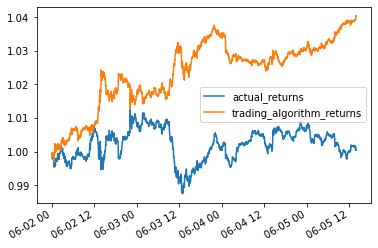

In [23]:
# Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`
(1 + predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot()